**Further train DeepCell Models with K's Data and Make Predictions**<br>
The model has three heads: inner distance, outer distance, and fgbg. It works on tensorflow 2.7.1.<br>
We first train a model with nucleus data from the Tissuenet V1.0 dataset and save the model. <br>
We then further train the model via deepcell.training.train_model_sample, which allows arbitrary size images and uses window_size to control patch size.
There are a total of 12,574 training instances.

In [1]:
starting_model_path = 'tn1.0_nuclear_20221102.h5' # the model trained with nucleus data from the Tissuenet V1.0 dataset
model_path = 'tn1.0_nuclear_K.h5' # the newly trained model
epochs=2 # 20 sec per step 
label="nuclear_K"

In [2]:
import syotil

import numpy as np
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline
from timeit import default_timer
import os
from skimage import img_as_ubyte

import deepcell
from deepcell import image_generators
from deepcell.utils.train_utils import rate_scheduler, get_callbacks, count_gpus
from deepcell_toolbox.utils import resize, tile_image, untile_image
from deepcell_toolbox.deep_watershed import deep_watershed
from deepcell.losses import weighted_categorical_crossentropy
from deepcell.model_zoo.panopticnet import PanopticNet

import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MSE

print(tf.__version__)
print(deepcell.__version__)

2.7.1
0.11.1


In [54]:
import glob
INPUT_PATH="images/training/"
#INPUT_PATH="images/training_512x512/"
FILENAMES = glob.glob(INPUT_PATH+"*_img.png")
print(len(FILENAMES))
print(FILENAMES)

7
['images/training/M872956_JML_Position9_CD3_train_img.png', 'images/training/M872956_JML_Position8_CD3_train_img.png', 'images/training/M926910_CFL_Position7_CD3_train_img.png', 'images/training/M926910_CFL_Position13_CD3_train_img.png', 'images/training/M872956_JML_Position8_CD8_train_img.png', 'images/training/M872956_JML_Position10_CD3_train_img.png', 'images/training/M872956_JML_Position8_CD4_train_img.png']


In [92]:
imgs = [io.imread(CURR_IM_NAME)[:,:,0] for CURR_IM_NAME in FILENAMES]
X_train = tf.stack(imgs)
X_train = np.expand_dims(X_train, axis=-1)
print(X_train.shape)

masks = [io.imread(CURR_IM_NAME.replace("img","masks")) for CURR_IM_NAME in FILENAMES]
y_train = tf.stack(masks)
y_train = np.expand_dims(y_train, axis=-1)
print(y_train.shape)

# np.savez("K_training_data", X=X_train, y=y_train) # objects to save need to be key value pairs
# train_dict, test_dict = get_data("K_training_data.npz", test_size=test_size, seed=seed)

(7, 1040, 1159, 1)
(7, 1040, 1159, 1)


In [56]:
# resize image
image_mpp=1
shape = X_train.shape
scale_factor = image_mpp / 0.65
new_shape = (int(shape[1] * scale_factor),
             int(shape[2] * scale_factor))

X_train = resize(X_train, new_shape, data_format='channels_last')
y_train = resize(y_train, new_shape, data_format='channels_last')
print(X_train.shape)

(7, 1599, 1783, 1)


In [20]:
# # write resized images and masks. saved to images/training_resized
# for i in range(7):
#     io.imsave(FILENAMES[i].replace("_img","_resized_img").replace("training","training_resized"), img_as_ubyte(X_train[i,:,:,0]))

# for i in range(7):
#     io.imsave(FILENAMES[i].replace("_img","_resized_masks").replace("training","training_resized"), img_as_ubyte(y_train[i,:,:,0]))

In [93]:
crop_size = (512, 512)
generator = image_generators.CroppingDataGenerator(
    featurewise_center=True,
    samplewise_center=True,
    featurewise_std_normalization=True,
    samplewise_std_normalization=True,
    zca_whitening=False,
    rotation_range=90.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.5,
    zoom_range=0.2,
    channel_shift_range=1.,
    brightness_range=(1, 5),
    fill_mode='nearest',
    cval=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=2,
    crop_size=crop_size)

# Basic test before fit
train_dict = {
    'X': np.random.random((7, 1599, 1783, 1)),
    'y': np.random.random((7, 1599, 1783, 1)),
}
train_dict2 = {
    'X': X_train, 
    'y': y_train,
}
test=generator.flow(train_dict2,
    min_objects=0
)


In [94]:
tmpX, tmpy = test.next()
tmpX.shape

(1, 512, 512, 1)

In [95]:
X_train.shape

(7, 1040, 1159, 1)

In [76]:
# create dataloader
crop_size = (512, 512)

seed=1
min_objects = 2

transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}

# use augmentation for training but not validation
# no need to define width_shift_range or height_shift_range 
# because crops will be taken randomly over the image and not just the center (cropping.py)
datagen = image_generators.CroppingDataGenerator(
#     crop_size=(512, 512),
# # datagen = image_generators.SemanticDataGenerator(
#     rotation_range=180,
#     fill_mode='reflect',
#     zoom_range=(0.75, 1.25),
#     horizontal_flip=True,
#     vertical_flip=True)
    featurewise_center=True,
    samplewise_center=True,
    featurewise_std_normalization=True,
    samplewise_std_normalization=True,
    zca_whitening=False,
    rotation_range=90.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.5,
    zoom_range=0.2,
    channel_shift_range=1.,
    brightness_range=(1, 5),
    fill_mode='nearest',
    cval=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=2,
    crop_size=crop_size
)    
    
datagen_val = image_generators.CroppingDataGenerator()

batch_size = 2 #1 causes an issue

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
#     transforms=transforms,
#     transforms_kwargs=transforms_kwargs,
    min_objects=0,
    batch_size=batch_size)

val_data = None
# datagen_val.flow(
#     {'X': X_val, 'y': y_val},
#     seed=seed,
#     transforms=transforms,
#     transforms_kwargs=transforms_kwargs,
#     min_objects=min_objects,
#     batch_size=batch_size)

# get number of training and validation instances

cnts_train = [np.max(y_train[i,...]) for i in range(y_train.shape[0])]
print(np.sum(cnts_train)) # total number of training instances

12574


In [77]:
tmpX, tmpy = train_data.next()
tmpX.shape

KeyboardInterrupt: 

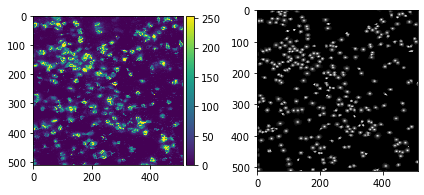

In [39]:
plt.subplot(1, 2, 1) # row 1, col 2 index 1
io.imshow(tmpX[0,:,:,0])
plt.subplot(1, 2, 2) # row 1, col 2 index 1
io.imshow(tmpy[0][0,:,:,0])
plt.show()

/app/software/scikit-image/0.19.1-foss-2021b/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


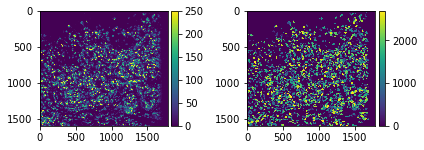

In [16]:
i=5
plt.subplot(1, 2, 1) # row 1, col 2 index 1
io.imshow(X_train[i,:,:,0])
plt.subplot(1, 2, 2) # row 1, col 2 index 1
# tmp = syotil.masks_to_outlines(y_train[i,:,:,0]); io.imshow(tmp)
io.imshow(y_train[i,:,:,0])
plt.show()

**The two cells below define and train the model.** They can be skipped if a trained model will be loaded.

In [40]:
semantic_classes = [1, 1, 2] # inner distance, outer distance, fgbg

model = PanopticNet(
    backbone='resnet50',
    input_shape=(512,512,1),
    norm_method='whole_image',
    num_semantic_classes=semantic_classes)

lr = 1e-4
optimizer = Adam(lr=lr, clipnorm=0.001)
lr_sched = rate_scheduler(lr=lr, decay=0.99)

# Create a dictionary of losses for each semantic head

def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss

loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)
        
model.compile(loss=loss, optimizer=optimizer)

model.load_weights(starting_model_path, by_name=True)

print([(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), model.layers)])

[('semantic_0', (None, 512, 512, 1)), ('semantic_1', (None, 512, 512, 1)), ('semantic_2', (None, 512, 512, 2))]


In [41]:
train_data.y.shape[0] // batch_size

14

In [47]:
epochs=10

In [48]:
# fit the model
print('Training on', count_gpus(), 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
#     monitor="val_loss",
    monitor='loss', # training loss
    verbose=1)          
            
loss_history = model.fit(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size, # 
    epochs=epochs, 
#     validation_data=val_data,
#     validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

model.save_weights(model_path)

Training on 3 GPUs.


2022-11-03 10:03:55.849270: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 14657 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 7.0
2022-11-03 10:03:55.850441: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 14657 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-11-03 10:03:55.851565: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 14657 MB memory:  -> device: 2, name: Tesla V100-PCIE-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0


Epoch 1/10
14/14 [==============================] - ETA: 0s - loss: 0.0201 - semantic_0_loss: 0.0080 - semantic_1_loss: 0.0104 - semantic_2_loss: 0.0017
Epoch 00001: loss improved from inf to 0.02011, saving model to tn1.0_nuclear_K.h5
14/14 [==============================] - 11s 760ms/step - loss: 0.0201 - semantic_0_loss: 0.0080 - semantic_1_loss: 0.0104 - semantic_2_loss: 0.0017 - lr: 1.0000e-04
Epoch 2/10
14/14 [==============================] - ETA: 0s - loss: 0.0198 - semantic_0_loss: 0.0079 - semantic_1_loss: 0.0102 - semantic_2_loss: 0.0017
Epoch 00002: loss improved from 0.02011 to 0.01981, saving model to tn1.0_nuclear_K.h5
14/14 [==============================] - 11s 802ms/step - loss: 0.0198 - semantic_0_loss: 0.0079 - semantic_1_loss: 0.0102 - semantic_2_loss: 0.0017 - lr: 9.9000e-05
Epoch 3/10
14/14 [==============================] - ETA: 0s - loss: 0.0194 - semantic_0_loss: 0.0076 - semantic_1_loss: 0.0101 - semantic_2_loss: 0.0017
Epoch 00003: loss improved from 0.01981

**Make prediction on K's data.**<br>
Using NuclearSegmentation allows setting image_mpp, which has a substantial influence on performance.

In [49]:
prediction_model = PanopticNet(
    backbone='resnet50',
    norm_method='whole_image',
    num_semantic_classes=[1, 1], # inner distance, outer distance
    input_shape= (512,512,1)
)

prediction_model.load_weights(model_path, by_name=True)

from deepcell.applications import NuclearSegmentation
app = NuclearSegmentation(prediction_model)
[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), app.model.layers)]

In [51]:
import os
print(os.getcwd())
INPUT_PATH="images/test/"
FILENAMES = [f for f in os.listdir("images/training/testimages")]
print(FILENAMES)

/home/yfong/deeplearning/dense_cell_segmentation
['M926910_CFL_Position7_CD3_test_img.png', 'M872956_JML_Position10_CD3_test_img.png', 'M872956_JML_Position8_CD8_test_img.png', 'M926910_CFL_Position13_CD3_test_img.png', 'M872956_JML_Position8_CD3_test_img.png', 'M872956_JML_Position8_CD4_test_img.png', 'M872956_JML_Position9_CD3_test_img.png']


In [53]:
APs={}
for CURR_IM_NAME in FILENAMES:
    im0 = io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME))
    mask_true=io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME.replace("img","masks")))

    x = np.expand_dims(im0, axis=-1)
    x = np.expand_dims(x, axis=0)
    y, tile_info = app._tile_input(x)
    print(x.shape)
    print(y.shape)
    print(tile_info)
    pred = app.predict(y, image_mpp=0.65) # what should image_mpp be?
    prd = app._untile_output(pred, tile_info)
    #io.imshow(prd[0,:,:,0])
    plt.show()
    
    APs[CURR_IM_NAME] = syotil.csi(mask_true, prd[0,:,:,0])# masks may lose one pixel if dimension is odd pixels

APs["mAP"]=np.mean(list(APs.values()))
print(APs)

(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
{'M926910_CFL_Position7_CD3_test_img.png': 0.14803149606299212, 'M872956_JML_Position10_CD3_test_img.png': 0.16666666666666666, 'M872956_JML_Position8_CD8_test_img.png': 0.3333333333333333, 'M926910_CFL_Position13_CD3_test_img.png': 0.08684863523573201, 'M872956_JML_Position8_CD3_test_img.png': 0.26063829787234044, 'M872956_JM

In [ ]:
import pandas as pd
df = pd.DataFrame([FILENAMES+["mAP"], list(APs.values())])
print(df.transpose())
df.to_csv('images/training/csi_tn_'+label+'.txt', index=False, header=False)

**mAP**<br>
image_mpp default: .<br>
image_mpp=1: .34<br>
image_mpp=2: .<br>